In [1]:
import os
# 使用ModelScope镜像
os.environ['UNSLOTH_USE_MODELSCOPE'] = '1'

# 导入必要的库
from unsloth import FastVisionModel  # 用于视觉模型，如果是语言模型则使用 FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# 支持的4bit量化模型列表，可以实现4倍更快的下载速度且不好发生内存溢出OOM
fourbit_models = [
    # Llama 3.2 系列视觉模型
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 支持视觉任务的指令版本
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # 可以在80GB显卡上运行
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    # Pixtral 系列视觉模型
    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral 可以在 16GB 显存上运行
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    # Qwen2 系列视觉模型
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL 视觉模型
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    # Llava 系列视觉模型
    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # 支持所有 Llava 变体!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # 更多模型可以在 https://huggingface.co/unsloth 上面找到

In [ ]:
# 加载模型和分词器
model, tokenizer = FastVisionModel.from_pretrained(
    # model_name="/home/zq/projects/models/unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit", # 选择加载本地模型
    model_name="/home/zq/projects/models/Qwen/Qwen3-VL-4B-Instruct", # 选择加载本地模型
    load_in_4bit = True, # 使用 4bit 量化减少内存使用。 False 则使用 16bit LoRA 训练
    use_gradient_checkpointing = "unsloth", # 设置为True 或者 "unsloth" 以支持更长的上下文，梯度检查点技术节省显存。Unsloth基于 transformers triton 实现的，都是HuggingFace出品的
)

==((====))==  Unsloth 2026.1.2: Fast Qwen3_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 4060 Ti. Num GPUs = 1. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

现在添加了 LoRA 适配器，用于参数高效微调 - 这使我们能够高效地训练所有参数的 1%。

[新功能] 还支持仅微调模型的视觉部分或语言部分。或者您可以选择两者！您还可以选择微调注意力或 MLP 层！

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # 是否微调视觉相关层
    finetune_language_layers   = False, # 是否微调语言相关层，语言模型不微调
    finetune_attention_modules = True, # 是否微调注意力相关层
    finetune_mlp_modules       = True, # 是否微调MLP层，影响验证集准确率

    # Lora 核心参数
    r = 16,           # 越大越准，但容易过拟合
    lora_alpha = 16,  # 推荐至少 alpha == r ，影响训练过程中的收敛速度和效果
    lora_dropout = 0, # dropout ratio 用于防止过拟合的手段
    bias = "none",    # 是否添加偏置项
    
    # 其它配置参数
    random_state = 3407, # 随机种子，确保使用可重复性
    use_rslora = False,  # 是否使用 rank stabilized LoRA
    loftq_config = None, # LoftQ 配置，用于量化
    # target_modules = "all-linear", # 可选项! 可以知道需要应用LoRA的具体模块
)

数据准备

###### 我们将使用手写数学公式的样本数据集。目标是将这些图像转换为计算机可读的形式 - 即 LaTeX 形式，以便我们可以渲染它。这对于复杂的公式非常有用。https://huggingface.co/datasets/unsloth/LaTeX_OCR https://huggingface.co/datasets/linxy/LaTeX_OCR

左边的渲染出来的公式（问题），右边是LaTex的文本（答案），datasets是hugging face的一个模块

In [5]:
from datasets import load_dataset
dataset = load_dataset("./data/unsloth/LaTeX_OCR", split = "train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

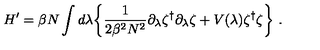

In [8]:
dataset[2]["image"]

In [9]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

In [10]:
# 可以直接通过浏览器渲染
from IPython.display import display, Math, Latex
latex = dataset[2]["text"]
display(Math(latex))

<IPython.core.display.Math object>

下面整理指令微调数据集

In [ ]:
# 所有的视觉微调任务，格式化形式如下，
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]

问题Q有两个，一个是 Image图片，一个是指令 instruction

In [11]:
instruction = "Write the LaTeX representation for this image." # 指令部分，问题的一部分

def convert_to_conversation(sample): # simple是数据集中的一条样本， 将数据集样本转换为对话格式
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",  # 助手，回答部分。Vision language Models 视觉语言模型
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }

上面是函数注册定义，下面是函数执行，做数据的转换，for把每个样本拿出来，交给上面封装好的函数做转换

In [12]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [ ]:
converted_dataset[0]  #  图片部分打印的是  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]}, 对应对应的类型是PIL，在python中是Pillow库中的Image类型; RGB是彩色图像红绿蓝三通道; 大小160x40像素

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTeX representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

在进行任何微调之前，让我们先看看第一个例子的模型输出是什么！

In [14]:
FastVisionModel.for_inference(model) # 推理模式! 训练之前把模型切换成推理模式，把数据传给他

image = dataset[2]["image"]                               # 找一条数据
instruction = "Write the LaTeX representation for this image."

messages = [                                             # 构建消息体
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True) # tokenizer转化成大模型可识别的输入格式
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)   # 创建一个TextStreamer，通过它可以实时输出生成的文本。  通过model.generate把输入给模型，给出相应的预测。
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,   # 输出的和真实的预测暂时还有差距
                   use_cache = True, temperature = 1.5, min_p = 0.1)

$$H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} .$$<|im_end|>


In [16]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

训练模型（预测的数据，和真实的数据有差距，如何能让差距更小，通过训练可以更小）

In [17]:
# 导入必要组件
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator  # 关于视觉的UnslothVisionDataCollator， 还有trainer
from trl import SFTTrainer, SFTConfig # 微调训练器和配置，有监督的训练器和配置

FastVisionModel.for_training(model) # 切换训练模式!  推理模式和训练模式，有什么区别么。

# 推理模式（预测出答案）：把输入进来的x，经过模型，得到输出y；给输入，得到输出完事。
# 训练模式（调参，他有真实的答案计算loss，反向传播求出梯度，根据梯度调整参数）：
    # 把输入进来的x，经过模型，得到输出y，除了输出，还有真实的标签。然后计算y和真实标签之间的loss，再将损失反向传播给model和和model参数更新。调整中loss不断下降，损失减小，预测的和真实的越来越小
# 训练的目的，是为了推理的时候，预测的结果更准确
# 去不需要具体实现

# 配置训练器
trainer = SFTTrainer(  # 构建训练器，对哪个模型训练，分词器，DataCollator读取数据对象，converted_dataset具体数（转换好的消息体，指令微调数据集），训练参数
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # 必须使用!
    train_dataset = converted_dataset,
    args = SFTConfig(
        # 基础训练参数
        per_device_train_batch_size = 2, # 每个设备的批次大小
        gradient_accumulation_steps = 4, # 梯度累积步数
        warmup_steps = 5,                # 预热步数（热身）
        max_steps = 30,                  # 最大训练步数（训练多少次迭代）
        # num_train_epochs = 1,          # 完整训练时设置此项，而不是 max_steps

        # 优化器、学习率设置
        learning_rate = 2e-4,            # 学习率（学习率策略）
        fp16 = not is_bf16_supported(),  #（参数类型）
        bf16 = is_bf16_supported(),
        optim = "adamw_8bit",            # 使用 8bit AdamW 优化器（采用哪一个优化器optimizer）
        weight_decay = 0.01,             # 权重衰减（学习率相关的衰减）
        lr_scheduler_type = "linear",    # 线性学习率调整器

        seed = 3407,                     # 随机种子

        # 日志和输出设置
        logging_steps = 1,      # 每步都记录日志
        output_dir = "outputs", # 输出目录
        report_to = "none",     # 不使用 Weights and Biases 记录

        # 视觉微调必须设置的以下参数:
        remove_unused_columns = False,  # 不移除未使用的列
        dataset_text_field = "",        # 数据集文本字段
        dataset_kwargs = {"skip_prepare_dataset": True},  # 数据集准备参数
        dataset_num_proc = 4,           # 数据处理的进程数量
        max_seq_length = 2048,          # 最大序列长度
    ),
)

Unsloth: Model does not have a default image size - using 512


In [18]:
# 显示当前内存信息
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4060 Ti. Max memory = 7.996 GB.
2.967 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()  # 核心，调用进行训练。  
                                # Lora的PEFT（参数高效微调）：0.14% trained，代表训练了0.14%的数据集，Lora算法，只会训练Lora Adapters部分的参数。原始模型是4,444,107,264 40 亿参数。只会训练6,291,456 600 多万参数。

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 6,291,456 of 4,444,107,264 (0.14% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.178000
2,1.403400
3,1.400800
4,1.175000
5,1.264100
6,1.512300
7,1.552300
8,1.244000
9,1.060200
10,1.376500


In [20]:
# 计算内存使用情况，单位GB
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3) # 总使用内存
used_memory_for_lora = round(used_memory - start_gpu_memory, 3) # LoRA 训练使用的额外内存

# 计算内存使用百分比
used_percentage = round(used_memory         /max_memory*100, 3)  # 总内存使用比例
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)  # LoRA 训练内存比例

# 打印训练时间统计
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.") # 训练用时 秒
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.") # 训练用时 分钟

# 打印内存使用统计
print(f"Peak reserved memory = {used_memory} GB.")  # 峰值占用内存
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.") # 训练过程额外使用的内存
print(f"Peak reserved memory % of max memory = {used_percentage} %.")  # 总内存使用百分比
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")  # 训练额外内存百分比

87.2888 seconds used for training.
1.45 minutes used for training.
Peak reserved memory = 3.271 GB.
Peak reserved memory for training = 0.304 GB.
Peak reserved memory % of max memory = 40.908 %.
Peak reserved memory for training % of max memory = 3.802 %.


让我们运行模型！您可以更改指令和输入，将输出留空！

In [21]:
FastVisionModel.for_inference(model) # 切换推理模式!

image = dataset[2]["image"]  # 从数据集中获取图片
instruction = "Write the LaTeX representation for this image."  # 设置指令

# 构建对话消息格式
messages = [
    {"role": "user", "content": [
        {"type": "image"},  # 图像输入
        {"type": "text", "text": instruction}  # 文本指令输入
    ]}
]

# 使用分词器处理输入
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True) # 应用chat模板
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,  # 不添加特殊 token
    return_tensors = "pt",       # 返回 pytorch 张量
).to("cuda")                     # 移到 GPU 上

# 设置文本生成的流式输出
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)  # 创建文本流式输出器，跳过提示部分

# 生成响应并捕获输出
output = model.generate(
    **inputs,                  # 输入数据
    streamer = text_streamer,  # 使用流式输出
    max_new_tokens = 128,      # 最大生成128个新token
    use_cache = True,          # 使用缓存加速生成
    temperature = 1.5,         # 温度参数，控制生成的随机性
    min_p = 0.1                # 最小概率阈值
)

$$H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} .$$<|im_end|>


In [19]:
dataset[2]["text"]

'H ^ { \\prime } = \\beta N \\int d \\lambda \\biggl \\{ \\frac { 1 } { 2 \\beta ^ { 2 } N ^ { 2 } } \\partial _ { \\lambda } \\zeta ^ { \\dagger } \\partial _ { \\lambda } \\zeta + V ( \\lambda ) \\zeta ^ { \\dagger } \\zeta \\biggr \\} \\ .'

保存和加载。保存Lora模型，

In [22]:
model.save_pretrained("lora_model") # 本地保存
tokenizer.save_pretrained("lora_model")

[]

保存Lora模型之后，加载并使用

In [ ]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "Write the LaTeX representation for this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)  # temperature 控制随机性，模型生成答案的时候问题有多高，温度越高，答案随机性越大

==((====))==  Unsloth 2026.1.2: Fast Qwen3_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 4060 Ti. Num GPUs = 1. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

$$\frac { N } { M } \in \mathbb { Z } , \frac { M } { P } \in \mathbb { Z } , \frac { P } { Q } \in \mathbb { Z }$$<|im_end|>


我们还支持直接保存为 float16。对于 float16，请选择 merged_16bit

In [ ]:
# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer)

In [ ]:
# 合并模型，把原生的模型 和训练好的lora参数合并，保存为一个完整的模型
if True: model.save_pretrained_merged("unsloth_finetune", tokenizer, save_method="merged_4bit")